# Preparación de datos

In [1]:
# importaciones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from pandas.plotting import scatter_matrix
from itertools import combinations

## Utilidades

In [2]:
# Configuración

# Esta variable es utilizada para controlar la ejecución de generación de boxplots durante el tratamiento de datos
EJECUCION_RAPIDA = True

# Semilla para asegurar
seed=9603

# Proporción de la muestra extraída del dataset original para entrenar los modelos de Machine Learning
# dataset_size = 0.2173197777948736
dataset_size = 0.0757828836335171
test_size = 0.2
valid_size = 0.25

# Nombres de archivos
dataset_path = "DB/"

db_files_name = ["df_train.csv", "df_test.csv"]

output_paths = ["output/", "../4_modelado/DB/"]

output_files_name = ["X_train.csv", "y_train.csv", "X_test.csv", "y_test.csv"]

img_path = "img/"

managed_path = "managed/"

no_managed_path = "no_managed/"

pca_path = "pca/"

boxplot_path = "boxplot/"

corr_matrix_path = "corr_matrix/"

In [3]:
# Variables

caracteristica_objetivo = ['label']

caracteristicas_nominales = ['destination_port']

caracteristicas_binarias  = [
      'fwd_psh_flags', 'fwd_urg_flags',
      'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
      'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
      'cwe_flag_count', 'ece_flag_count'
]
      
caracteristicas_numericas = [
      'flow_duration', 'total_fwd_packets', 'total_backward_packets', 
      'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
      'fwd_packet_length_max', 'fwd_packet_length_min', 
      'fwd_packet_length_mean', 'fwd_packet_length_std', 
      'bwd_packet_length_max', 'bwd_packet_length_min', 
      'bwd_packet_length_mean', 'bwd_packet_length_std', 
      'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 
      'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 
      'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 
      'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 
      'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
      'min_packet_length', 'max_packet_length', 'packet_length_mean',
      'packet_length_std', 'packet_length_variance', 'down/up_ratio',
      'average_packet_size', 'avg_fwd_segment_size', 
      'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 
      'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 
      'init_win_bytes_forward', 'init_win_bytes_backward', 
      'act_data_pkt_fwd', 'min_seg_size_forward', 'active_mean', 
      'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 
      'idle_max', 'idle_min'
]

caracteristicas_no_utiles = [
      'bwd_psh_flags',
      'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'
]

caracteristicas_con_valor_maximo_infinito = [
      'flow_bytes/s', 'flow_packets/s'
]

In [4]:
# getFrequency(): Función para obtener la distribución de frecuencias de la columna label
def getFrequency(df : pd.DataFrame, caracteristica) :
  frecuencia = df[caracteristica].value_counts()
  porcentaje = df[caracteristica].value_counts(normalize=True) * 100

  tabla_frecuencia = pd.DataFrame({
    "Frecuencia": frecuencia,
    "Frecuencia(%)": porcentaje
  })
  
  tabla_frecuencia["Frecuencia(%)"].round(2)
  
  print(tabla_frecuencia)
  print(df.shape)

In [5]:
# generateBoxplot(): Función para generar boxplot 
def generateBoxplot(x, y, data, save_path="", save = True) :
  sns.boxplot(x=x, y=y, data=data)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.title(f"Boxplot {y} {x}")
  plt.tight_layout()
  if save :
    plt.savefig(save_path)
  plt.show()

In [6]:
# generateCorrMatrix(): Función para generar matriz de correlación
def generateCorrMatrix(data, save_path="", title="Matriz de correlación", method="pearson", width=32, height=24, fontsize=12,decimals=2, abs = False, save=True) :
  # Generación de matriz de correlación
  matriz_correlacion = data.corr(method=method).round(decimals=decimals)

  if abs :
    matriz_correlacion = matriz_correlacion.abs()

  # Generación de mapa de calor para visualizar los datos
  plt.figure(figsize=(width, height))

  sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(title)
  plt.tight_layout()
  if save:
    plt.savefig(save_path)
  plt.show()
  return matriz_correlacion

## Carga y transformación de datos

### Carga de datos

In [7]:
# Carga de datos
df = pd.read_csv(f"{dataset_path}dataset.csv")
print("Datos cargados")

Datos cargados


### Transformación de nombres de columnas y etiquetas de variable objetivo

In [8]:
# Transformación de nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)
print(f"Total de características: {len(df.columns)}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [9]:
# Transformación de nombres de etiquetas de la columna label
df["label"] = df["label"].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
print(df["label"].unique())
print(f"Total de etiquetas: {len(df["label"].unique())}")

['BENIGN' 'FTP_PATATOR' 'SSH_PATATOR' 'DOS_SLOWLORIS' 'DOS_SLOWHTTPTEST'
 'DOS_HULK' 'DOS_GOLDENEYE' 'WEB_ATTACK_BRUTE_FORCE' 'WEB_ATTACK_XSS'
 'BOT' 'PORTSCAN' 'DDOS']
Total de etiquetas: 12


### División en conjuntos de entrenamiento, validación y pruebas

In [10]:
# Frecuencia del conjunto de datos extraído
getFrequency(df=df, caracteristica="label")

                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                     1743179      75.765455
DOS_HULK                    231073      10.043347
PORTSCAN                    158930       6.907726
DDOS                        128027       5.564560
DOS_GOLDENEYE                10293       0.447374
FTP_PATATOR                   7938       0.345017
SSH_PATATOR                   5897       0.256307
DOS_SLOWLORIS                 5796       0.251917
DOS_SLOWHTTPTEST              5499       0.239008
BOT                           1966       0.085450
WEB_ATTACK_BRUTE_FORCE        1507       0.065500
WEB_ATTACK_XSS                 652       0.028338
(2300757, 79)


In [11]:
# Extracción de muestra
df_vector_test, df_temp = train_test_split(
  df, 
  test_size=1-dataset_size, 
  stratify=df["label"], 
  random_state=seed
)

df_vector, df_test = train_test_split(
  df_vector_test,
  test_size=test_size,
  stratify=df_vector_test["label"],
  random_state=seed
)

df_train, df_valid = train_test_split(
  df_vector,
  test_size=valid_size,
  stratify=df_vector["label"],
  random_state=seed
)

print("Dataset para el proyecto")
getFrequency(df=df_vector_test, caracteristica="label")

Dataset para el proyecto
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                      132102      75.765240
DOS_HULK                     17511      10.043187
PORTSCAN                     12044       6.907666
DDOS                          9702       5.564445
DOS_GOLDENEYE                  780       0.447358
FTP_PATATOR                    602       0.345269
SSH_PATATOR                    447       0.256371
DOS_SLOWLORIS                  439       0.251782
DOS_SLOWHTTPTEST               417       0.239164
BOT                            149       0.085457
WEB_ATTACK_BRUTE_FORCE         114       0.065383
WEB_ATTACK_XSS                  50       0.028677
(174357, 79)


In [12]:
# Tablas de frecuencia de conjuntos de entrenamiento, validación y prueba
print("Dataset de entrenamiento")
getFrequency(df=df_train, caracteristica="label")
print("\nDataset de validación")
getFrequency(df=df_valid, caracteristica="label")
print("\nDataset de prueba")
getFrequency(df=df_test, caracteristica="label")

Dataset de entrenamiento
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260      75.764962
DOS_HULK                     10507      10.043685
PORTSCAN                      7226       6.907363
DDOS                          5821       5.564318
DOS_GOLDENEYE                  468       0.447363
FTP_PATATOR                    361       0.345081
SSH_PATATOR                    269       0.257138
DOS_SLOWLORIS                  263       0.251403
DOS_SLOWHTTPTEST               251       0.239932
BOT                             89       0.085075
WEB_ATTACK_BRUTE_FORCE          68       0.065001
WEB_ATTACK_XSS                  30       0.028677
(104613, 79)

Dataset de validación
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       26421      75.765657
DOS_HULK                      3502      10.042441
PORTSCAN                      2409     

## Tratamiento del conjunto de entrenamiento

### Selección de datos relevantes

In [13]:
df_train = df_train.drop(caracteristicas_no_utiles, axis=1)
print(df_train.columns)
print(f"N° características: {len(df_train.columns.tolist())}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',

### Limpieza de datos

In [14]:
# Imputación de datos faltantes y nulos
# No se identificó una relación mediante la matriz de correlación, sin embargo, se imputarán los datos en razón de la variable objetivo para conservar la mayor información ppsible

# imputacion_con_filtro_datos_faltantes() : Imputación de datos faltantes con la mediana, se aplican las medianas filtrando por la variable objetivo
def imputacion_con_filtro_datos_faltantes(df : pd.DataFrame, caracteristica : str) : 
  imputacion_con_filtro = True
  if imputacion_con_filtro :
    print(df[df[caracteristica].isna()]["label"].value_counts())
    # Se obtienen las etiquetas de la variable objetivo que tienen valores nulos
    null_values_list = df[df[caracteristica].isna()]["label"].unique().tolist()

    for i in null_values_list : 
      # Obtención de mediana de la columna filtrandolo por la variable objetivo
      median = df[df["label"] == i][caracteristica].median()

      # Reemplazo de valores faltantes por la mediana obtenida
      df.loc[df[caracteristica].isnull() & (df["label"] == i), caracteristica] = median

      # Cálculo de posibles características que no se hayan imputado
      rest = df[df["label"] == i][caracteristica].isnull().sum()

      print(f"Mediana de la característica {caracteristica} en la etiqueta {i}: {median}")
      print(f"Valores faltantes en {caracteristica} en {i} después de la imputación: {rest}")
  else : 
    # Posible imputación sin filtros
    # Obtención de mediana general de la columna
    mediana = df[caracteristica].median()

    # Reemplazo de todos los valores faltantes por la mediana general
    df[caracteristica] = df[caracteristica].fillna(mediana)
    print(f"Mediana de la característica {caracteristica}: {mediana}\n")
    print(f"Valores faltantes en {caracteristica}: {df[caracteristica].isnull().sum()}")
  return df

df_train = imputacion_con_filtro_datos_faltantes(df=df_train, caracteristica="flow_bytes/s")

label
DOS_HULK    36
BENIGN      18
Name: count, dtype: int64
Mediana de la característica flow_bytes/s en la etiqueta DOS_HULK: 121.1820345
Valores faltantes en flow_bytes/s en DOS_HULK después de la imputación: 0
Mediana de la característica flow_bytes/s en la etiqueta BENIGN: 5029.361045
Valores faltantes en flow_bytes/s en BENIGN después de la imputación: 0


In [15]:
# Manejo de outliers

# manageOutliersToMinMax() : Función para manejar outliers y transformarlos a los valores mínimos y máximos en un boxplot aplicando filtros en la variable objetivo
def manageOutliersToMinMax(df : pd.DataFrame, col_num, col_obj) :
  df_modificado = df.copy()
  for var_obj in df[col_obj].unique() :
    subset = df[df[col_obj] == var_obj]
    q1 = subset[col_num].quantile(0.25)
    q3 = subset[col_num].quantile(0.75) 
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    valid_values = subset[(subset[col_num] >= lower_bound) & (subset[col_num] <= upper_bound)][col_num]
    valid_min = valid_values.min()
    valid_max = valid_values.max()

    mask = df[col_obj] == var_obj
    df_modificado.loc[mask & (df[col_num] < lower_bound), col_num] = valid_min
    df_modificado.loc[mask & (df[col_num] > upper_bound), col_num] = valid_max
  return df_modificado

# Manejo de outliers para ajustarlos al máximo y mínimo del conjunto de datos según la variable objetivo
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  df_train = manageOutliersToMinMax(df=df_train,col_num=i,col_obj="label")

print("Outliers manejados")

Outliers manejados


In [ ]:
# La característica destination_port es de tipo categórica y tiene alta cardinalidad
# por ello, se aplicará reducción de características mediante la clasificación de IANA
"""
  Clasificación de IANA de puertos
  0 - 1023 : Well-known ports, puertos utilizados por el sistema (o root) o programas con privilegios de usuario 
  1024 - 49151 : Registered ports, puertos utilizados en procesos o programas de usuarios ordinarios
  49152 - 65535 : Dynamic and/or Private ports, puertos privados o dinámicos
"""

chars_encoder = OneHotEncoder(drop="first", sparse_output=False)

bins = [-1, 1023, 49151, 65535]
labels = ["well_known", "registered", "dynamic_private"]
df_train["port_type"] = pd.cut(df_train["destination_port"], bins=bins, labels=labels)

chars_encoded_array = chars_encoder.fit_transform(df_train[["port_type"]])
df_chars_encoded = pd.DataFrame(
  columns=chars_encoder.get_feature_names_out(),
  data=chars_encoded_array
)

df_train = pd.concat(
  [
    df_chars_encoded.reset_index(drop=True), 
    df_train[caracteristicas_binarias + caracteristicas_numericas + caracteristicas_con_valor_maximo_infinito + caracteristica_objetivo].reset_index(drop=True)
  ],
  axis=1
)

df_train

,port_type_registered,port_type_well_known,fwd_psh_flags,fwd_urg_flags,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,...,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,flow_bytes/s,flow_packets/s,label
0,0.0,1.0,0,0,0,0,0,0,1,1,...,0.0,0,0,0.0,0.0,0,0,0.000000,54.473648,BENIGN
1,0.0,1.0,0,0,0,0,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,0.000000,6.383780,BENIGN
2,1.0,0.0,1,0,0,1,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,53333.333330,BENIGN
3,0.0,1.0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0,10933.978800,166.930974,BENIGN
4,1.0,0.0,0,0,0,0,0,1,0,0,...,0.0,0,0,0.0,0.0,0,0,115384.615400,38461.538460,PORTSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104608,0.0,1.0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,19138.755980,BENIGN
104609,1.0,0.0,1,0,0,1,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,691983.122400,53333.333330,BENIGN
104610,0.0,1.0,0,0,1,0,0,0,0,0,...,0.0,5002,5000,98400000.0,0.0,98400000,98400000,121.417204,0.132141,DOS_HULK
104611,0.0,1.0,0,0,0,0,0,0,1,0,...,0.0,0,0,0.0,0.0,0,0,0.000000,5117.707267,DOS_HULK


### Creación de nuevos datos

In [18]:
# SMOTE y Tomek-links son un sistema que funcionan en base a los vecinos más cercanos
# SMOTE es un sistema que realiza un sobremuestreo de la clase minoritaria para equilibrar las clases 
# Tomek-links es un sistema que realiza un submuestreo eliminando registros de la clase minoritaria selectivamente para equlibrar las clases 

In [32]:
# Creación de SMOTE y Tomek links
# SMOTENC() : Permite sobremuestrear registros incluyendo características categóricas
smt_nc = SMOTENC(
  categorical_features=list(range(len(list(chars_encoder.get_feature_names_out()) + caracteristicas_binarias))),
  random_state=seed
)

# TomekLinks() : Elimina registros del dataset de forma determinística, por ello, no es necesario usar una seed
tmk = TomekLinks()

print("Distribución inicial")
getFrequency(df=df_train, caracteristica="label")

Distribución inicial
                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260      75.764962
DOS_HULK                     10507      10.043685
PORTSCAN                      7226       6.907363
DDOS                          5821       5.564318
DOS_GOLDENEYE                  468       0.447363
FTP_PATATOR                    361       0.345081
SSH_PATATOR                    269       0.257138
DOS_SLOWLORIS                  263       0.251403
DOS_SLOWHTTPTEST               251       0.239932
BOT                             89       0.085075
WEB_ATTACK_BRUTE_FORCE          68       0.065001
WEB_ATTACK_XSS                  30       0.028677
(104613, 72)


In [ ]:
# Sobre-muestreo con SMOTE
X_train_resample, y_train_resample = smt_nc.fit_resample(
  df_train.drop(["label"], axis=1),
  df_train["label"] 
)
getFrequency(df=y_train_resample.to_frame(), caracteristica="label")

                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                       79260       8.333333
PORTSCAN                     79260       8.333333
DOS_HULK                     79260       8.333333
DDOS                         79260       8.333333
DOS_SLOWLORIS                79260       8.333333
SSH_PATATOR                  79260       8.333333
DOS_GOLDENEYE                79260       8.333333
BOT                          79260       8.333333
WEB_ATTACK_BRUTE_FORCE       79260       8.333333
DOS_SLOWHTTPTEST             79260       8.333333
FTP_PATATOR                  79260       8.333333
WEB_ATTACK_XSS               79260       8.333333
(951120, 1)


In [ ]:
# Sub-muestreo con Tomek-links
# Usamos un conjunto para obtener una lista de los índices sin repetir
indices_para_remover = set()
labels = y_train_resample.to_frame()["label"].unique()
cont = 0

for i, j in combinations(labels, 2) :
  print(f"Iteración {cont}")
  cont += 1 
  ohe = OneHotEncoder(drop="first", sparse_output=False)

  mask = y_train_resample.isin([i, j])

  X_pair =  X_train_resample[mask]
  y_pair = ohe.fit_transform(y_train_resample[mask].to_frame())
  
  tmk = TomekLinks()
  X_tmk_resample, y_tmk_resample = tmk.fit_resample(X_pair, y_pair)

  indices_conservados = X_pair.index[tmk.sample_indices_]
  indices_removidos = set(X_pair.index) - set(indices_conservados)

  indices_para_remover.update(indices_removidos)

X_train_clean = X_train_resample.drop(index=indices_para_remover)
y_train_clean = y_train_resample.drop(index=indices_para_remover)
getFrequency(df=y_train_clean.to_frame(), caracteristica="label")

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\ids_thesis\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\User\anaconda3\envs\ids_thesis\Li

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]

### Selección de características

#### Obtención de residuos

C:\Users\User\AppData\Local\Temp\ipykernel_33972\1701543742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residuos[caracteristica_objetivo] = y_train_clean.to_frame()[caracteristica_objetivo]


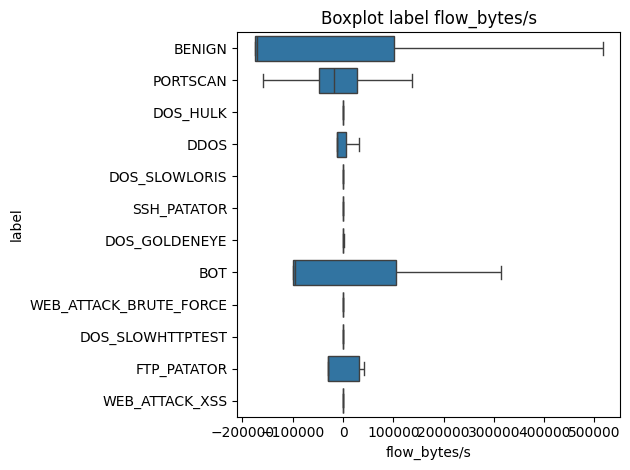

In [ ]:
# Creación del dataframe de residuos
df_residuos = X_train_clean[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito]
df_residuos[caracteristica_objetivo] = y_train_clean.to_frame()[caracteristica_objetivo]

def obtener_residuos(df: pd.DataFrame, obj_char : str, caracteristica : str) :
  df_new = df.copy()
  obj_tags = df_new[obj_char].unique()
  for i in obj_tags : 
    mask = df_new[obj_char] == i
    mean = df_new[mask][caracteristica].mean()
    df_new.loc[mask, caracteristica] = df_new[mask][caracteristica] - mean
  return df_new

for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  df_residuos = obtener_residuos(df=df_residuos, obj_char=caracteristica_objetivo, caracteristica=i)
# generateBoxplot(x="flow_bytes/s", y="label", data=df_residuos, save=False)

#### Prueba de normalidad 

In [51]:
# Prueba de Shapiro Wilk
df_shapiro_wilk = pd.DataFrame(columns=["característica", "estadístico", "p_valor", "pasa"])
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  statistic, p_value = stats.shapiro(df_residuos[i])
  df_shapiro_wilk.loc[len(df_shapiro_wilk)] = [i, statistic, p_value, p_value >= 0.05]
df_shapiro_wilk

c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 947746.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\User\anacon

,característica,estadístico,p_valor,pasa
0,flow_duration,0.586028,2.648564e-203,False
1,total_fwd_packets,0.725610,3.715184e-188,False
2,total_backward_packets,0.525024,1.689850e-208,False
3,total_length_of_fwd_packets,0.494897,7.626569e-211,False
4,total_length_of_bwd_packets,0.496578,1.022723e-210,False
5,fwd_packet_length_max,0.655294,1.738916e-196,False
6,fwd_packet_length_min,0.289947,4.494496e-224,False
7,fwd_packet_length_mean,0.661179,7.505732e-196,False
8,fwd_packet_length_std,0.650041,4.804955e-197,False
9,bwd_packet_length_max,0.510825,1.276529e-209,False


In [52]:
# Prueba de Kolmogorov Smirnov
df_kolmogorov_smirnov = pd.DataFrame(columns=["característica", "estadístico", "p_valor", "pasa"])
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito :
  statistic, p_value = stats.kstest((df_residuos[i]-df_residuos[i].mean())/df_residuos[i].std(), stats.norm.cdf)
  df_kolmogorov_smirnov.loc[len(df_kolmogorov_smirnov)] = [i, statistic, p_value, p_value >= 0.05]
df_kolmogorov_smirnov

,característica,estadístico,p_valor,pasa
0,flow_duration,0.346874,0.0,False
1,total_fwd_packets,0.247074,0.0,False
2,total_backward_packets,0.287411,0.0,False
3,total_length_of_fwd_packets,0.326845,0.0,False
4,total_length_of_bwd_packets,0.424664,0.0,False
5,fwd_packet_length_max,0.344432,0.0,False
6,fwd_packet_length_min,0.430388,0.0,False
7,fwd_packet_length_mean,0.306207,0.0,False
8,fwd_packet_length_std,0.386337,0.0,False
9,bwd_packet_length_max,0.414474,0.0,False


#### Prueba Kruskal Wallis

In [55]:
df_train_clean = X_train_clean[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito]
df_train_clean["label"] = y_train_clean.to_frame()

df_kruskal = pd.DataFrame(columns=["caracteristica", "estadistico", "p_valor", "pasa"])

for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  grupos = [group[i].values for name, group in df_train_clean.groupby('label')]

  stat, p_value = stats.kruskal(*grupos)
  df_kruskal.loc[len(df_kruskal)] = [i, stat, p_value, p_value < 0.05]

df_kruskal.sort_values(by='estadistico', ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_33972\3044818024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_clean["label"] = y_train_clean.to_frame()


,caracteristica,estadistico,p_valor,pasa
10,bwd_packet_length_min,661372.898086,0.0,True
46,init_win_bytes_backward,649981.554094,0.0,True
30,bwd_packets/s,646384.417609,0.0,True
58,flow_packets/s,643206.428663,0.0,True
29,fwd_packets/s,615302.108685,0.0,True
48,min_seg_size_forward,597965.199823,0.0,True
13,flow_iat_mean,596058.426209,0.0,True
57,flow_bytes/s,580122.587760,0.0,True
20,fwd_iat_max,577611.593360,0.0,True
15,flow_iat_max,562553.935193,0.0,True


In [ ]:
df_kruskal

# Revisión de características

In [ ]:
len(df_train["destination_port"].unique())

24233